In [85]:
import re
import json
import requests
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from descartes.patch import PolygonPatch
from collections import defaultdict
from collections import OrderedDict
from IPython.display import HTML
from shapely.geometry import Point

In [86]:
from sklearn.exceptions import DataConversionWarning

warnings.simplefilter(action="ignore", \
                      category=FutureWarning)

warnings.filterwarnings(action='ignore', \
                        category=DataConversionWarning)

In [87]:
listings = pd.read_csv("listings_full.csv", dtype={"neighbourhood":str})

cols_to_drop = list(filter(lambda x: "cleansed" in x, listings.columns))
listings = listings.drop(labels=cols_to_drop, axis=1)

for i in range(0, len(listings.columns), 10):
    columns = listings.columns[i:i+10]
    display(listings[columns].head())

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url
0,2265,https://www.airbnb.com/rooms/2265,2.020000e+13,12-02-2021,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,NaN,https://a0.muscache.com/pictures/4740524/63f82...,2466,https://www.airbnb.com/users/show/2466
1,5245,https://www.airbnb.com/rooms/5245,2.020000e+13,12-02-2021,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,NaN,https://a0.muscache.com/pictures/5167505/b33b5...,2466,https://www.airbnb.com/users/show/2466
2,5456,https://www.airbnb.com/rooms/5456,2.020000e+13,12-02-2021,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028
3,5636,https://www.airbnb.com/rooms/5636,2.020000e+13,12-02-2021,"Soco, Barton Springs Private Guest Cottage",MONTHLY Short Term <br />Located in the awesom...,This area is one of the top areas in Austin to...,https://a0.muscache.com/pictures/17705/ef0b703...,7148,https://www.airbnb.com/users/show/7148
4,5769,https://www.airbnb.com/rooms/5769,2.020000e+13,13-02-2021,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186


,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url
0,Paddy,23-08-2008,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,90%,f,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...
1,Paddy,23-08-2008,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,90%,f,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...
2,Sylvia,16-02-2009,"Austin, Texas, United States",I am a licensed Real Estate Broker and owner o...,within a few hours,100%,91%,t,https://a0.muscache.com/im/users/8028/profile_...,https://a0.muscache.com/im/users/8028/profile_...
3,Peggy,27-01-2009,"Austin, Texas, United States",Friendly host who enjoys meeting new people o...,within a few hours,100%,100%,f,https://a0.muscache.com/im/users/7148/profile_...,https://a0.muscache.com/im/users/7148/profile_...
4,Elizabeth,19-02-2009,"Austin, Texas, United States",We're easygoing professionals that enjoy meeti...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/8186/profile_...,https://a0.muscache.com/im/users/8186/profile_...


,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_location,neighbourhood,latitude,longitude
0,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,NaN,78702,30.27750,-97.71398
1,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,NaN,78702,30.27577,-97.71379
2,East Downtown,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Austin, Texas, United States",78702,30.26112,-97.73448
3,Bouldin Creek,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Austin, Texas, United States",78704,30.24630,-97.76361
4,SW Williamson Co.,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Austin, Texas, United States",78729,30.45697,-97.78422


,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights
0,Entire house,Entire home/apt,4,NaN,2 baths,2.0,2.0,"[""Free parking on premises"", ""Hair dryer"", ""Pa...",$200.00,7
1,Private room in house,Private room,2,NaN,1 private bath,1.0,2.0,"[""Free parking on premises"", ""Hair dryer"", ""Br...",$114.00,30
2,Entire guesthouse,Entire home/apt,3,NaN,1 bath,1.0,2.0,"[""Hair dryer"", ""Dishes and silverware"", ""Air c...",$104.00,2
3,Entire guesthouse,Entire home/apt,2,NaN,1 bath,1.0,4.0,"[""Free parking on premises"", ""Stove"", ""Dishes ...",$46.00,30
4,Private room in house,Private room,2,NaN,1 shared bath,1.0,1.0,"[""Shampoo"", ""Indoor fireplace"", ""Hair dryer"", ...",$39.00,1


,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30
0,180,7.0,7.0,180.0,180.0,7.0,180.0,NaN,t,13
1,60,30.0,30.0,60.0,60.0,30.0,60.0,NaN,t,0
2,90,2.0,2.0,90.0,90.0,2.0,90.0,NaN,t,24
3,90,30.0,30.0,90.0,90.0,30.0,90.0,NaN,t,7
4,14,1.0,1.0,14.0,14.0,1.0,14.0,NaN,t,21


,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating
0,13,42,131,12-02-2021,24,0,0,17-03-2009,16-03-2019,93.0
1,0,0,0,12-02-2021,9,0,0,19-03-2009,14-03-2018,91.0
2,54,84,354,12-02-2021,543,20,3,08-03-2009,01-02-2021,97.0
3,37,67,67,12-02-2021,21,1,0,20-04-2009,06-11-2020,95.0
4,50,79,79,13-02-2021,259,2,1,10-04-2010,10-02-2021,98.0


,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes
0,9.0,10.0,10.0,10.0,8.0,9.0,NaN,f,3,2
1,10.0,8.0,10.0,9.0,10.0,9.0,NaN,f,3,2
2,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,1,1
3,9.0,10.0,10.0,10.0,10.0,9.0,NaN,f,2,2
4,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,0


,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1,0,0.17
1,1,0,0.06
2,0,0,3.74
3,0,0,0.15
4,1,0,1.96


<AxesSubplot:>

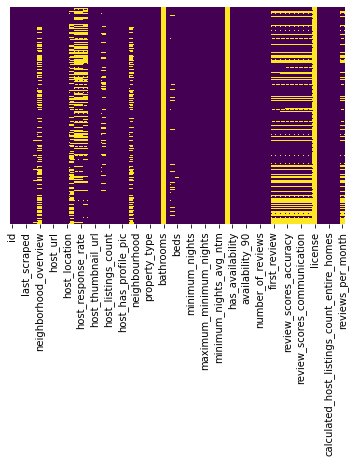

In [88]:
sns.heatmap(listings.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [89]:
listings_info = {"features": listings.columns, \
                 "entry count": [listings[column].count() \
                                 for column in listings.columns], \
                 "NaN count": [listings[column].isna().sum() \
                               for column in listings.columns]}

listings_info = pd.DataFrame(listings_info).set_index("features")
for i in range(0, len(listings_info), 30):
    display(listings_info.iloc[i:i+30])

,entry count,NaN count
features,,
id,10272,0
listing_url,10272,0
scrape_id,10272,0
last_scraped,10272,0
name,10272,0
description,10064,208
neighborhood_overview,6545,3727
picture_url,10270,2
host_id,10272,0


,entry count,NaN count
features,,
property_type,10272,0
room_type,10272,0
accommodates,10272,0
bathrooms,0,10272
bathrooms_text,10256,16
bedrooms,9577,695
beds,10209,63
amenities,10272,0
price,10272,0


,entry count,NaN count
features,,
review_scores_accuracy,7489,2783
review_scores_cleanliness,7489,2783
review_scores_checkin,7488,2784
review_scores_communication,7488,2784
review_scores_location,7483,2789
review_scores_value,7483,2789
license,0,10272
instant_bookable,10272,0
calculated_host_listings_count,10272,0


In [90]:
listings["neighbourhood"].isnull().sum()

0

In [91]:
verifications = listings["host_verifications"]

verifications = verifications.apply(lambda row: eval(row) \
                                    if row != "None" else [])
verifications = verifications.apply(lambda row: len(row))

listings["host_verifications_count"] = verifications

display(listings[["host_verifications_count", \
                  "host_verifications"]].max().head())

host_verifications_count    12
host_verifications          []
dtype: object

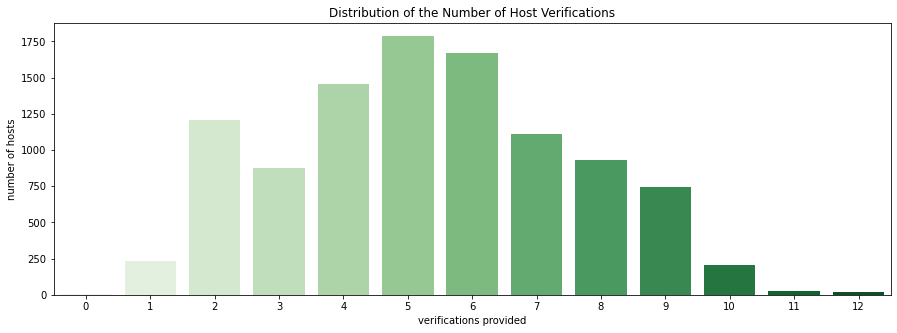

The no. of hosts that didn't undergo any verification: 6
The no. of hosts that underwent 12 verifications: 22


In [92]:
counts = listings["host_verifications_count"]

f, axes = plt.subplots(figsize=(15,5))
ax = sns.countplot(x=counts, palette="Greens")
ax.set(title="Distribution of the Number of Host Verifications", \
       xlabel="verifications provided", ylabel="number of hosts")
plt.show()

print("The no. of hosts that didn't undergo any verification: %d" \
      % len(listings[counts == 0]))
print("The no. of hosts that underwent 12 verifications: %d" \
      % len(listings[counts == 12]))

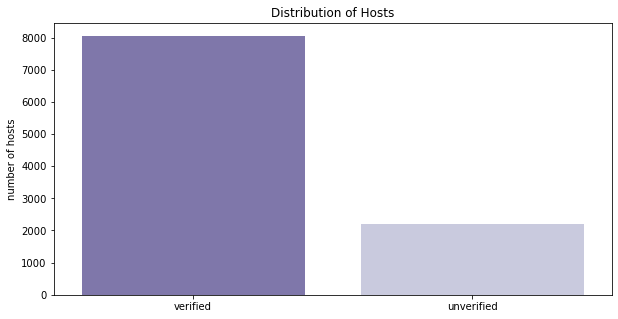

The number of verified hosts: 8051
The number of unverified hosts: 2216


In [93]:
f, axes = plt.subplots(figsize=(10,5))
ax = sns.countplot(x=verified, palette="Purples_r")
ax.set(title="Distribution of Hosts", \
       xlabel="", ylabel="number of hosts")
ax.set_xticklabels(["verified", "unverified"])
plt.show()

print("The number of verified hosts: %d" \
      % len(listings[verified == "t"]))
print("The number of unverified hosts: %d" \
      % len(listings[verified == "f"]))

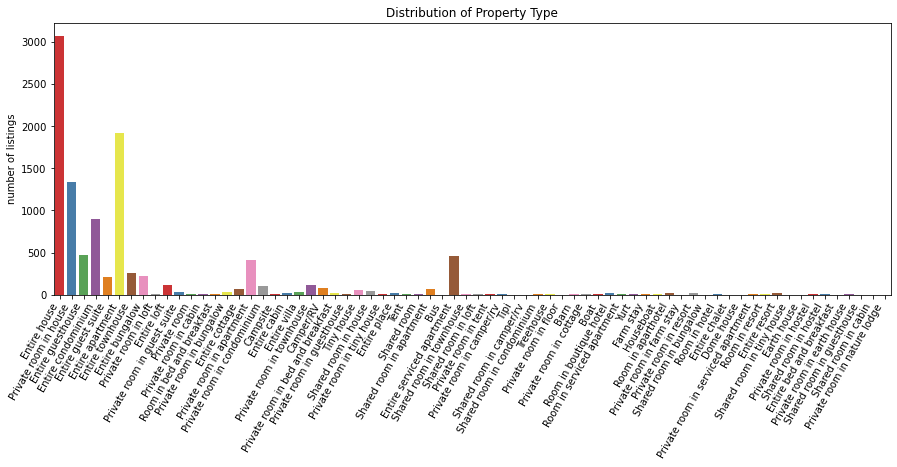

In [95]:
f, axes = plt.subplots(figsize=(15,5))
ax = sns.countplot(x=property_type, palette="Set1")
ax.set(title="Distribution of Property Type", \
       xlabel="", ylabel="number of listings")
ax.set_xticklabels(labels=property_type.unique(), \
                   rotation=60, ha="right")
plt.show()

Here in the above graph we can see Entire house/apartment followed by private rooms have highest no. of listings.

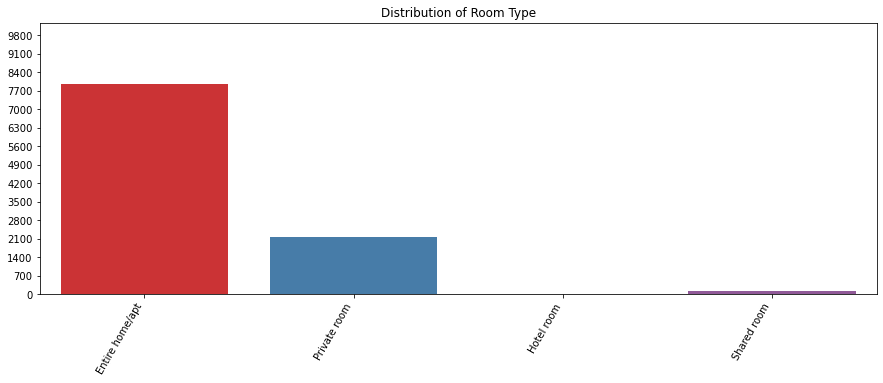

In [96]:
count = len(listings)
ticks = [idx for idx in range(0, count, 700)]

property_type = listings["property_type"]
room_type = listings["room_type"]
bed_type = listings["beds"]


f, axes = plt.subplots(1, 1, figsize=(15,5))



ax = sns.countplot(x=room_type, palette="Set1")
ax.set(title="Distribution of Room Type", \
       xlabel="", ylabel="", \
       ylim=[0,count], yticks=ticks)
ax.set_xticklabels(labels=room_type.unique(), \
                   rotation=60, ha="right")

plt.show()

Silimalarly in this graph too we can see Entire house/apartment followed by private rooms have highest no. of listings.

In [97]:
austin_map = gpd.read_file("neighbourhoods.geojson")
austin_map["neighbourhood"] = austin_map["neighbourhood"]

print(type(austin_map))
display(austin_map.head(25))

<class 'geopandas.geodataframe.GeoDataFrame'>


,neighbourhood,neighbourhood_group,geometry
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ..."
1,78754,None,"MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ..."
2,78732,None,"MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ..."
3,78737,None,"MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ..."
4,78756,None,"MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ..."
5,78747,None,"MULTIPOLYGON (((-97.73617 30.15986, -97.73591 ..."
6,78751,None,"MULTIPOLYGON (((-97.70677 30.32211, -97.70693 ..."
7,78712,None,"MULTIPOLYGON (((-97.73366 30.28536, -97.73295 ..."
8,78738,None,"MULTIPOLYGON (((-98.00622 30.36079, -98.00424 ..."
9,78725,None,"MULTIPOLYGON (((-97.62338 30.26459, -97.62126 ..."


# Map of neighbourhood based on Room_Type

<ipython-input-98-15412d3af7e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_df["Point"] = listings_df.apply(lambda row: \
<ipython-input-98-15412d3af7e1>:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  geo_df.apply(lambda x: ax.annotate(s=x.name, \


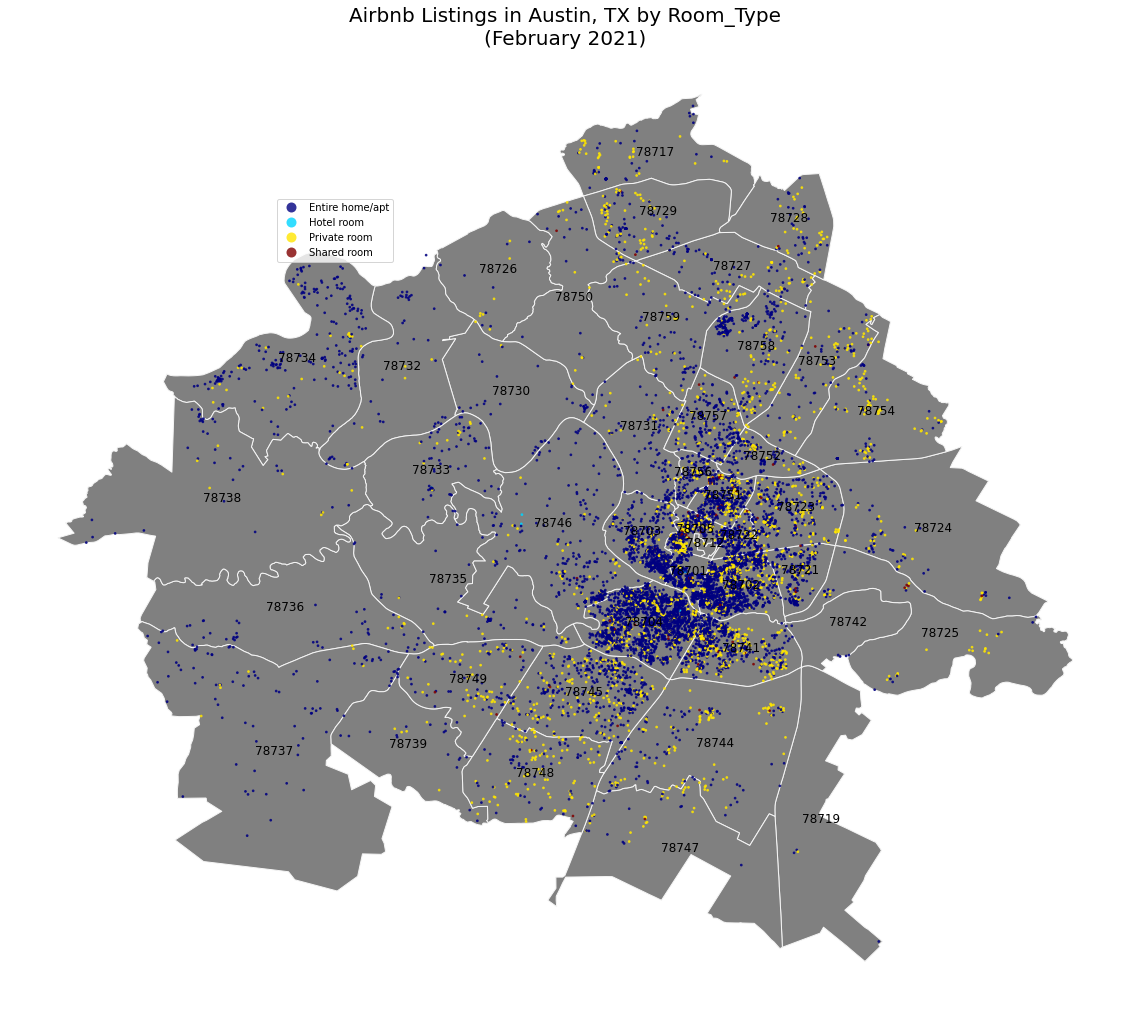

In [98]:
listings_df = listings[["neighbourhood", "id", "latitude", "longitude", \
                           "room_type"]]
listings_df["Point"] = listings_df.apply(lambda row: \
                                         Point(row["longitude"], \
                                               row["latitude"]), axis=1)
listings_df = gpd.GeoDataFrame(listings_df, geometry="Point")

geo_df = listings_df.groupby("neighbourhood").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="neighbourhood")
geo_df = geo_df.set_index("neighbourhood")

fig, ax = plt.subplots(figsize=(20,20))

base = geo_df.plot(color="grey", \
                   edgecolor="whitesmoke", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=12, color="black"), axis=1)
base.axis("off")

listings_df.plot(ax=base, cmap="jet", marker="o", markersize=3, \
                 alpha=.8, column="room_type", \
                 categorical=True, legend=True)

legend = ax.get_legend()
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("Airbnb Listings in Austin, TX by Room_Type\n(February 2021)", \
          fontdict={"fontsize":20})

plt.show()

In the above map we can see that majority of people love to have Entire room/apts followed by private room. We can see that majority of listing as well as Entire room/apt & private rooms are present in neighbourhood 78757, 78752, 78756, 78751, 78723, 78703, 78705, 78722, 78701, 78709, 78704, 78717 & 78745. 

In [99]:
df = listings[["neighbourhood", "price"]]
df.head(10)

,neighbourhood,price
0,78702,$200.00
1,78702,$114.00
2,78702,$104.00
3,78704,$46.00
4,78729,$39.00
5,78704,$99.00
6,78704,$139.00
7,78702,$500.00
8,78704,$190.00
9,78759,$158.00


In [100]:
price = df["price"].apply(lambda row: row[1:])
price = price.apply(lambda row: "".join(row.split(",")))
price = price.astype(float)

df["price"] = price

<ipython-input-100-22c05dd885fa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price"] = price


In [101]:
df.head(10)

,neighbourhood,price
0,78702,200.0
1,78702,114.0
2,78702,104.0
3,78704,46.0
4,78729,39.0
5,78704,99.0
6,78704,139.0
7,78702,500.0
8,78704,190.0
9,78759,158.0


# Top area with highest no. of listings :

<ipython-input-102-bf3d11be74c3>:9: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  price_df.apply(lambda x: ax.annotate(s=x.name, \
<ipython-input-102-bf3d11be74c3>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])


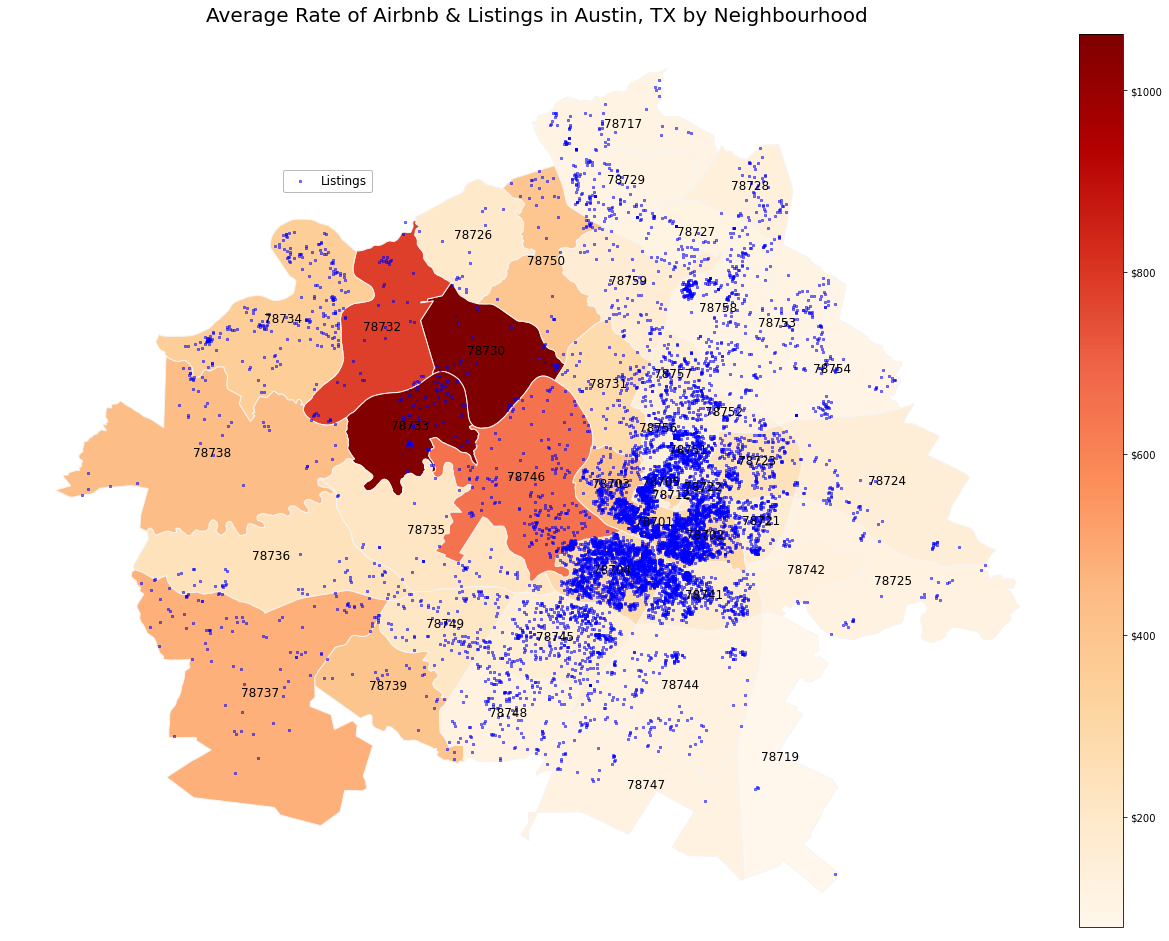

In [102]:
price_df = df.pivot_table(index="neighbourhood", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="neighbourhood")
price_df = price_df.set_index("neighbourhood")

fig, ax = plt.subplots(figsize=(20,20))

base = price_df.plot(column="price", cmap="OrRd", \
                     edgecolor="whitesmoke", ax=ax)
price_df.apply(lambda x: ax.annotate(s=x.name, \
                                     xy=x.geometry.centroid.coords[0], \
                                     ha="center", fontweight="light", \
                                     fontsize=12, color="black"), axis=1)
base.axis("off")

min_price = price_df["price"].min()
max_price = price_df["price"].max()
gradient = plt.cm.ScalarMappable(cmap="OrRd", \
                                 norm=plt.Normalize(vmin=min_price, \
                                                    vmax=max_price))
gradient._A = []
cbar = fig.colorbar(gradient, fraction=0.04, pad=.01)

listings_df.plot(ax=base, color="blue", marker="s", markersize=1.5, \
                 alpha=.5, label="Listings")

cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])

legend = plt.legend(facecolor="w", edgecolor="darkgray", fontsize=12)
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("Average Rate of Airbnb & Listings in Austin, TX by Neighbourhood", \
          fontdict={"fontsize":20})

plt.show()

In the above map it is shown that the no of listings are higher in neighbourhood 78757, 78752, 78756, 78751, 78723, 78703, 78705, 78722, 78701, 78709, 78704, 78717 & 78745.
Neighbourhood 78732, 78730, 78733 & 78746 have highest average rates.

<ipython-input-103-51abac6963a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df["Point"] = reviews_df.apply(lambda row: \
<ipython-input-103-51abac6963a5>:18: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  price_df.apply(lambda x: ax.annotate(s=x.name, \
<ipython-input-103-51abac6963a5>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])


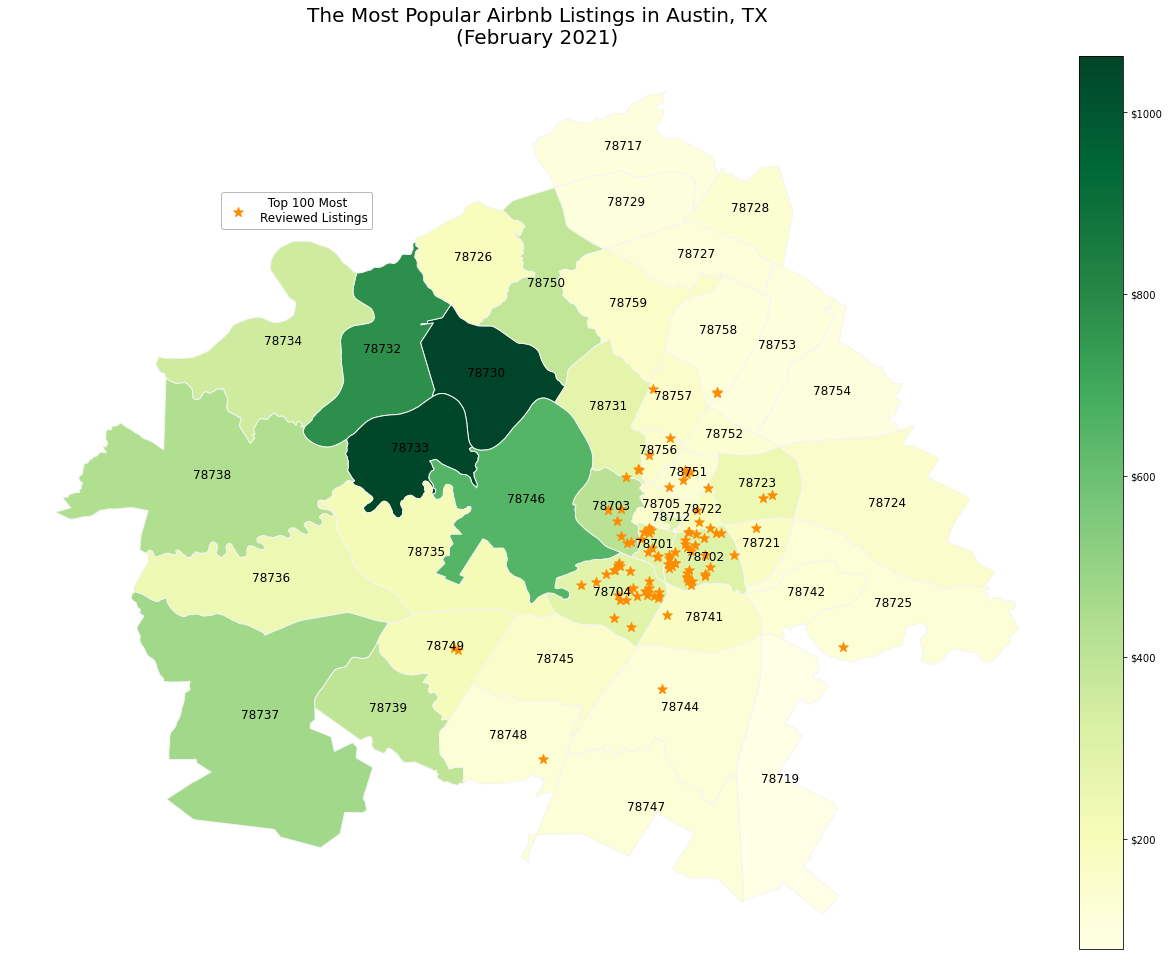

In [103]:
reviews_df = listings[["neighbourhood", "id", "latitude", "longitude", \
                         "number_of_reviews"]]
reviews_df["Point"] = reviews_df.apply(lambda row: \
                                       Point(row["longitude"], \
                                             row["latitude"]), axis=1)
reviews_df = gpd.GeoDataFrame(reviews_df, geometry="Point")
reviews_df = reviews_df.sort_values("number_of_reviews", ascending=False)
reviews_df = reviews_df.iloc[0:100]

price_df = df.pivot_table(index="neighbourhood", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="neighbourhood")
price_df = price_df.set_index("neighbourhood")

fig, ax = plt.subplots(figsize=(20,20))

base = price_df.plot(column="price", cmap="YlGn", \
                   edgecolor="whitesmoke", ax=ax)
price_df.apply(lambda x: ax.annotate(s=x.name, \
                                     xy=x.geometry.centroid.coords[0], \
                                     ha="center", fontweight="light", \
                                     fontsize=12, color="black"), axis=1)
base.axis("off")

min_price = price_df["price"].min()
max_price = price_df["price"].max()
gradient = plt.cm.ScalarMappable(cmap="YlGn", \
                                 norm=plt.Normalize(vmin=min_price, \
                                                    vmax=max_price))
gradient._A = []
cbar = fig.colorbar(gradient, fraction=0.04, pad=.01)

reviews_df.plot(ax=base, color="darkorange", marker="*", markersize=100, \
                alpha=1, label="  Top 100 Most\nReviewed Listings")

cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])

legend = plt.legend(facecolor="w", edgecolor="darkgray", fontsize=12)
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("The Most Popular Airbnb Listings in Austin, TX\n(February 2021)", \
          fontdict={"fontsize":20})

plt.show()

The above map shows Top 100 Most Reviewed Listing in Austin, TX

<ipython-input-104-c05a51295253>:15: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  geo_df.apply(lambda x: ax.annotate(s=x.name, \


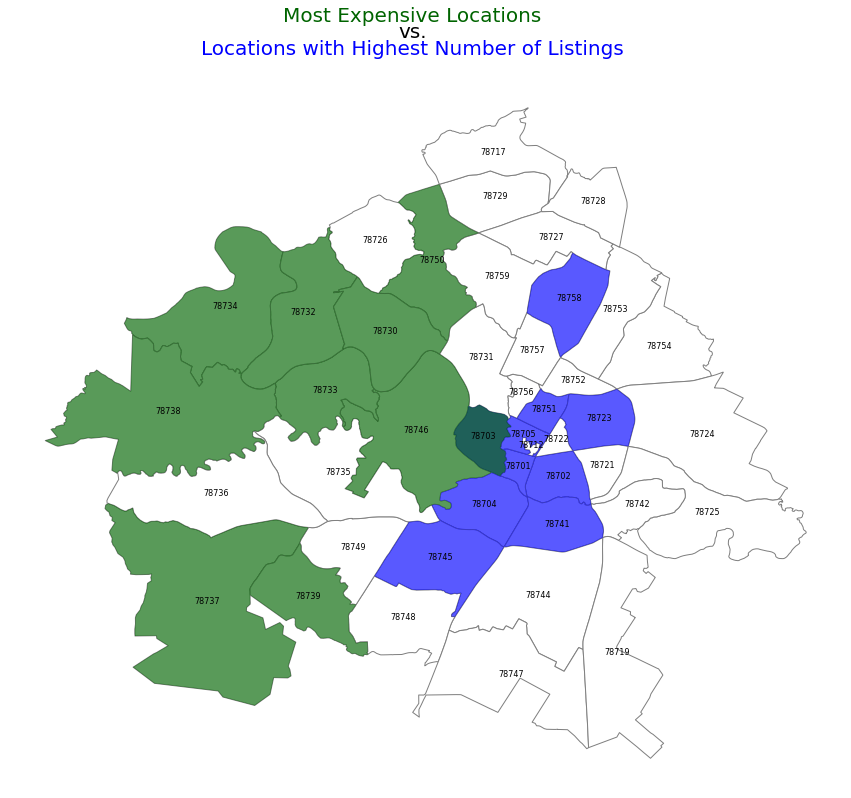

In [104]:
price_df = df.pivot_table(index="neighbourhood", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="neighbourhood")
price_df = price_df.sort_values("price", ascending=False)
price_df = price_df[["neighbourhood", "geometry", "price"]].set_index("neighbourhood")

geo_df = listings_df.groupby("neighbourhood").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="neighbourhood")
geo_df = geo_df.sort_values("id", ascending=False)
geo_df = geo_df[["neighbourhood", "geometry", "id"]].set_index("neighbourhood")

fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="w", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

geo_df[["geometry", "id"]][0:10].plot(color="blue", alpha=0.65, \
                                      ax=base)

price_df[["geometry", "price"]][0:10].plot(color="darkgreen", \
                                           alpha=0.65, ax=base)

fig.text(0.500, 0.880, "Most Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.500, 0.865, "vs.", ha="center", va="bottom", size=20)
fig.text(0.500, 0.850, "Locations with Highest Number of Listings", \
         ha="center", va="bottom", size=20,color="blue")

plt.show()

The above map shows area/neighbourhoods having Highest no. of listings and neighbourhoods with Most expensive locations. 

In [105]:
pd.set_option('display.max_columns', None)

# Top hosts having higher total no. of listings :

In [106]:
listings.nlargest(100, ['host_total_listings_count']).head(100)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_location,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_verifications_count
10022,47816741,https://www.airbnb.com/rooms/47816741,2.020000e+13,12-02-2021,Convenient Room Double Bed At Austin,A towering icon within Austin's vibrant Centra...,NaN,https://a0.muscache.com/pictures/ca9a8ccc-d16a...,175128252,https://www.airbnb.com/users/show/175128252,Team Gospodin,24-02-2018,"London, England, United Kingdom",NaN,within an hour,100%,99%,f,https://a0.muscache.com/im/pictures/user/85d75...,https://a0.muscache.com/im/pictures/user/85d75...,LB of Harrow,7235.0,7235.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,NaN,78701,30.26213,-97.73960,Private room in bed and breakfast,Private room,2,NaN,1 private bath,1.0,1.0,"[""Hair dryer"", ""Bathtub"", ""Hot water"", ""Coffee...",$205.00,1,365,1.0,1.0,365.0,365.0,1.0,365.0,NaN,t,28,58,88,363,12-02-2021,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,0,1,0,NaN,7
6140,32207144,https://www.airbnb.com/rooms/32207144,2.020000e+13,12-02-2021,"Club Wyndham Austin, Texas, 2 Bedroom Presiden...",Wyndham Austin - Texas - 2 Bedroom Suite<br />...,Resort Description:<br /><br />Discover the st...,https://a0.muscache.com/pictures/57b67226-1b14...,194953121,https://www.airbnb.com/users/show/194953121,Christian,11-06-2018,United States,My team and I have access to 917+ resorts thro...,within an hour,100%,99%,f,https://a0.muscache.com/im/pictures/user/c2fa2...,https://a0.muscache.com/im/pictures/user/c2fa2...,Table Rock,2753.0,2753.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Austin, Texas, United States",78701,30.27259,-97.74805,Entire condominium,Entire home/apt,6,NaN,2 baths,2.0,3.0,"[""Hair dryer"", ""Bathtub"", ""Game console"", ""Air...",$256.00,2,182,1.0,2.0,7.0,30.0,1.5,18.3,NaN,t,0,15,45,320,12-02-2021,10,0,0,12-05-2019,20-01-2020,87.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN,t,45,45,0,0,0.47,7
6141,32207608,https://www.airbnb.com/rooms/32207608,2.020000e+13,12-02-2021,"Relaxing Club Wyndham Austin, Studio",Wyndham Austin - Texas - Studio<br /><br /><b>...,Resort Description:<br /><br />Discover the st...,https://a0.muscache.com/pictures/04f5ef0f-4284...,194953121,https://www.airbnb.com/users/show/194953121,Christian,11-06-2018,United States,My team and I have access to 917+ resorts thro...,within an hour,100%,99%,f,https://a0.muscache.com/im/pictures/user/c2fa2...,https://a0.muscache.com/im/pictures/user/c2fa2...,Table Rock,2753.0,2753.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Austin, Texas, United States",78701,30.27216,-97.74656,Entire house,Entire home/apt,4,NaN,1 bath,1.0,2.0,"[""Hair dryer"", ""Bathtub"", ""Game console"", ""Air...",$170.00,2,182,1.0,2.0,7.0,30.0,1.5,18.3,NaN,t,16,46,76,351,12-02-2021,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,45

The host named Team Gospodin has highest host_total_listings_count (i.e.7235) followed by Christian who is the host of many places.  